# Ensemble Methods

Surprisingly many weak learners (one that is a little better than random) voting on a class performs in many cases better than a strong learner.

This is because of the law of large numbers. For example, imagine tossing a coin that lands on heads 51% of the time and 49% on tails. After tossing the coin 1000 times, we'd expect about 510 heads and 490 tails. It turns out with 1000 tosses, there's a 75% chance of guessing heads. With 10000 tosses, we're at 97% chance of guessing heads.

With an infinite number of tosses, the ratio approaches the exact probability distribution of the coin which is 51% heads 49% tails. In this case, the ensemble of weak learners will always predict heads.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np

iris = datasets.load_iris()
X = iris["data"][:,2:] #Only care about last 2 features
print(X.shape)
print(iris.keys())
y = iris["target"].astype(np.float64)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,
                                                   random_state=42)

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators=[("lr", log_clf),("rnd", rnd_clf),("svm", svm_clf)],
    voting="hard"
)

voting_clf.fit(X_train,y_train)

(150, 2)
dict_keys(['DESCR', 'data', 'feature_names', 'target_names', 'target'])


VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rnd', Random...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [25]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test,y_pred))
    

LogisticRegression 0.8666666666666667
RandomForestClassifier 1.0
SVC 1.0
VotingClassifier 1.0


/home/edwardchaos/.local/share/virtualenvs/TF_py3/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Bagging and Pasting


Bagging and Pasting are methods where instead of training different types of classifiers, we train an ensemble of same type classifiers but with different subsets of data.

Bagging: Sampling with replacement
Pasting: Sampling without replacement

In [26]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=100,
    bootstrap=True, #With replacement
    n_jobs=-1
)

bag_clf.fit(X_train,y_train)
y_pred = bag_clf.predict(X_test)

In [27]:
print(accuracy_score(y_test,y_pred))

1.0


### Out-of-bag Evaluation

With bagging, since replacement is allowed, there may be instances that are sampled multiple times and others that are not sampled at all. The ones that are not sampled are called "out of bag" (oob) instances. Since the classifier never sees these instances, they can be used in validating performance.

In this way, the effect of cross-validation is free

In [28]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    n_jobs=-1,
    oob_score=True
)

In [29]:
bag_clf.fit(X_train,y_train)
bag_clf.oob_score_

0.9416666666666667

In [30]:
bag_clf.oob_decision_function_

array([[1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.06761006, 0.93238994],
       [0.        , 0.99481865, 0.00518135],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.00505051, 0.99494949],
       [0.        , 0.90449438, 0.09550562],
       [0.        , 0.99418605, 0.00581395],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.44632768, 0.55367232],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.

## Random Patches and Random Subspaces

Instead of boostrapping on training instances, we can instead boostrap on individual features. This is particularly useful in datasets with high dimensionaly such as images. 

Bootstrapping on instances AND features is called "Random Patches"
Bootstrapping only on features is called "Random Subspaces"


Bootstrapping BIAS vs. VARIANCE tradeoff:
- Boot strapping increases bias and reduces variance
    - Since each classifier has less data to work with, it "underfits" more hence increased bias.
    - All classifiers in the ensemble in a way have slightly different decision boundaries that constrains the solution space in slightly differnet ways hence decreases the variance of the ensemble as a whole


## Random Forests

RandomForestClassifier is a customized BaggingClassifier just for decision trees.

Instead of splitting greedily on the next best feature when growing a tree, RandomForest by default chooses the best split from a set of randomly selected features. This in turn reduces correlation between individual decision trees thereby further increasing bias and reducing variance.

In [31]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500,
                                max_leaf_nodes=16,
                                n_jobs=-1)

rnd_clf.fit(X_train,y_train)
y_pred = rnd_clf.predict(X_test)

## Extra-Trees

Extremely Randomized Trees further increase bias and reduce variance.

Instead of any sort of greedy selection while growing a tree, both attribute AND tolerance are selected randomly.

This is the epitome of "weak learners"

This is faster to train, so could probably train more weak learners and hope on the law of large numbers to carry

## Feature Importance

In [32]:
from sklearn.datasets import load_iris

In [36]:
rnd_clf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
iris = load_iris()
rnd_clf.fit(iris['data'], iris['target'])

#Display importance of features
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name,score)

sepal length (cm) 0.09665730257203743
sepal width (cm) 0.022836607349913437
petal length (cm) 0.4313242460751427
petal width (cm) 0.4491818440029059


Takeaway: Random Forests are a great way to quickly get a sense of which features are the most important.

## Boosting

Training classifiers sequentially, each improving on the previous.

Does not scale as well as Bagging since each predictor relies on the training of its predecessor.

### AdaBoost

AdaBoost focuses on trainig examples that were predicted incorreclty. Potentially the most popular boosting strategy, AdaBoost works by setting equal weights for all training instances initially. The weights for incorrectly classified instances are increased so that the next classifier would focus more on these. 

Typically AdaBoost is an ensemble of "decision stumps" (decision trees with depth=1).

In [40]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import ExtraTreeClassifier

ada_clf = AdaBoostClassifier(
    ExtraTreeClassifier(max_depth=1),
    n_estimators=200,
    algorithm="SAMME.R",
    learning_rate=0.5
)

ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=ExtraTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_decrease=0.0, min_impurity_split=None,
          min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=None,
          splitter='random'),
          learning_rate=0.5, n_estimators=200, random_state=None)

### Gradient Boosting

Instead of modifying instance weights as with AdaBoost, Gradient Boost optimizes incrementally on the residual errors.

A.K.A.
Gradient Tree Boosting
Gradient Boosted Regression Trees

In [46]:
#A step by step demonstration of how gradient boosting works

from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [42]:
y2 = y-tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X,y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [43]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X,y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [45]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

### Using Sklearn's GradientBoostingRegressor Class

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2,
                                 n_estimators=3,
                                 learning_rate=1.0)

gbrt.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

The learning_rate parameter is a hyperparameter that controls how much each tree's predictions contribute towards the ensemble prediction.

A lower value requires more trees in the ensemble but also generally improves generalisability.

One way of selecting the number of trees is with early stopping.

#### Early Stopping

In [57]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train,X_val,y_train,y_val = train_test_split(X,y)

gbrt = GradientBoostingRegressor(max_depth=2,n_estimators=120)
gbrt.fit(X_train,y_train)

errors=[mean_squared_error(y_val, y_pred)
           for y_pred in gbrt.staged_predict(X_val)]

best_numberof_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=best_numberof_estimators)
gbrt_best.fit(X_train,y_train)
print(len(gbrt_best.estimators_))

95


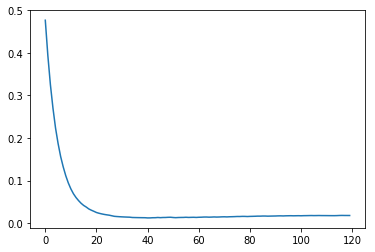

In [54]:
num_estimators = len(errors)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(num_estimators), errors)

Early stopping without having to compute trees up to high num of learners. Instead, use "warm_start" to continue where it last left off everytime you call fit()

In [55]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error=float("inf")
error_going_up = 0
for n_estimators in range(1,120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train,y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val,y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            #To account for noise, we don't want to stop as soon as
            #Error goes up once.
            break; #Stop early

In [58]:
print(len(gbrt.estimators_))

120


## Stacking (Stacked Generalization)

In ensemble methods we've discussed previously, the scores of individual predictors are aggregated as one by means of statistical mode, or weighted based on prediction probability.

Stacking abstracts this step away from the user by embedding this aggregation into the model. 

Simplest explaination (Ensemble of 3 predictors):

Step 1: Split training set into 2 parts. One for the usual training of predictors and one for training the "blender".

Step 2: Use the first training set to train the predictors as usual. This sets the weights of the predictors accordingly.

Step 3: Use the second set as inputs to the trained predictors to generate 3 outputs. By using examples the predictors haven't seen before, we get "clean" outputs so they're not overfitted.

Step 4: Use the 3 outputs to train a "blender" that outputs a single class/value. A blender can be any type (Linear Regressor, Random Forest Regression, etc.)

Step 5: Finally, the output of the blender is the overall predicted class.

Scikit learn doesn't provide Stacks directly but can be built with individual components.